![insomnia](insomnia.jpg)


Your client, SleepInc, has shared anonymized sleep data from their hot new sleep tracking app SleepScope. As their data science consultant, your mission is to analyze the lifestyle survey data with Python to discover relationships between exercise, gender, occupation, and sleep quality. See if you can identify patterns leading to insights on sleep quality.

## 💾 The data: sleep_health_data.csv

SleepInc has provided you with an anonymized dataset of sleep and lifestyle metrics for 374 individuals. This dataset contains average values for each person calculated over the past six months. The data is saved as `sleep_health_data.csv`.

The dataset includes 13 columns covering sleep duration, quality, disorders, exercise, stress, diet, demographics, and other factors related to sleep health. 

| Column | Description |
|---------|----------------------------------------|  
| `Person ID` | An identifier for each individual. |
| `Gender` | The gender of the person (Male/Female). |  
| `Age` | The age of the person in years. |
| `Occupation` | The occupation or profession of the person. |
| `Sleep Duration (hours)` | The average number of hours the person sleeps per day. |
| `Quality of Sleep (scale: 1-10)` | A subjective rating of the quality of sleep, ranging from 1 to 10. |
| `Physical Activity Level (minutes/day)` | The average number of minutes the person engages in physical activity daily. |  
| `Stress Level (scale: 1-10)` | A subjective rating of the stress level experienced by the person, ranging from 1 to 10. |
| `BMI Category` | The BMI category of the person (e.g., Underweight, Normal, Overweight). |
| `Blood Pressure (systolic/diastolic)` | The average blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure. |
| `Heart Rate (bpm)` | The average resting heart rate of the person in beats per minute. |
| `Daily Steps` | The average number of steps the person takes per day. |
| `Sleep Disorder` | The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea). |

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, ttest_ind, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data_path = "sleep_health_data.csv"
data = pd.read_csv(data_path)

In [16]:
# Display basic information about the dataset
print("Dataset Head:\n", data.head())
print("\nDataset Info:\n")
data.info()
print("\nMissing Values:\n", data.isnull().sum())

# Handle Missing Values (if any)
data.dropna(inplace=True)  # Dropping rows with missing values (can be modified)

# Descriptive Statistics
print("\nDescriptive Statistics:\n", data.describe())

# Convert Categorical Data to Numeric if Needed
label_encoders = {}
categorical_columns = ["Gender", "Occupation", "BMI Category", "Sleep Disorder"]
for col in categorical_columns:
    if (col in data.columns) and (data[col].dtype == 'object'):
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))  # Ensure consistent encoding
        label_encoders[col] = le
# Print a confirmation message
print("Categorical columns encoded:", list(label_encoders.keys()))

Dataset Head:
    Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         126/83          77         4200            NaN  
1         125/80   

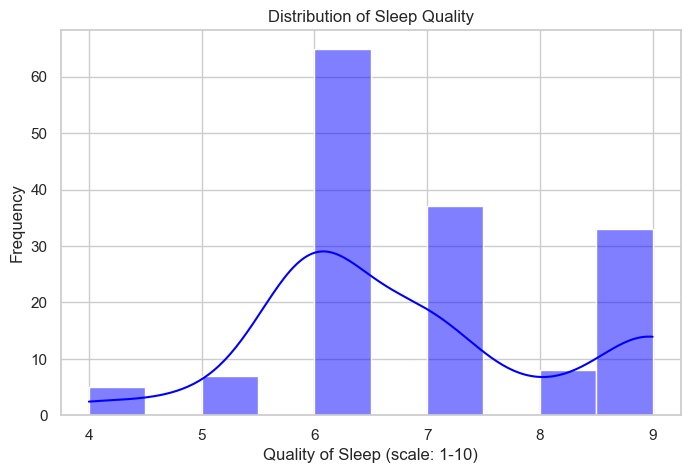

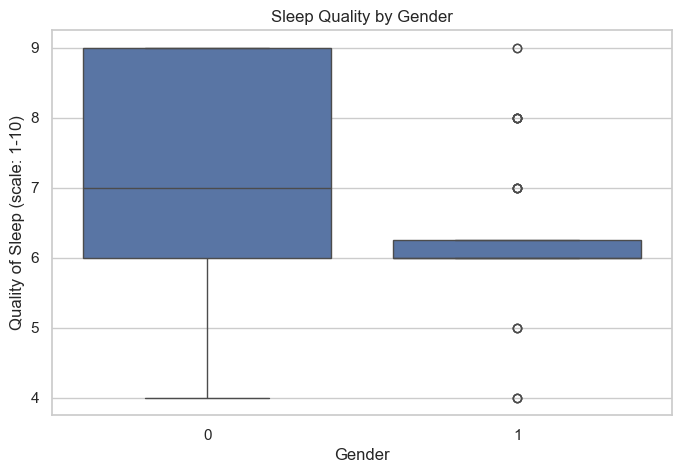

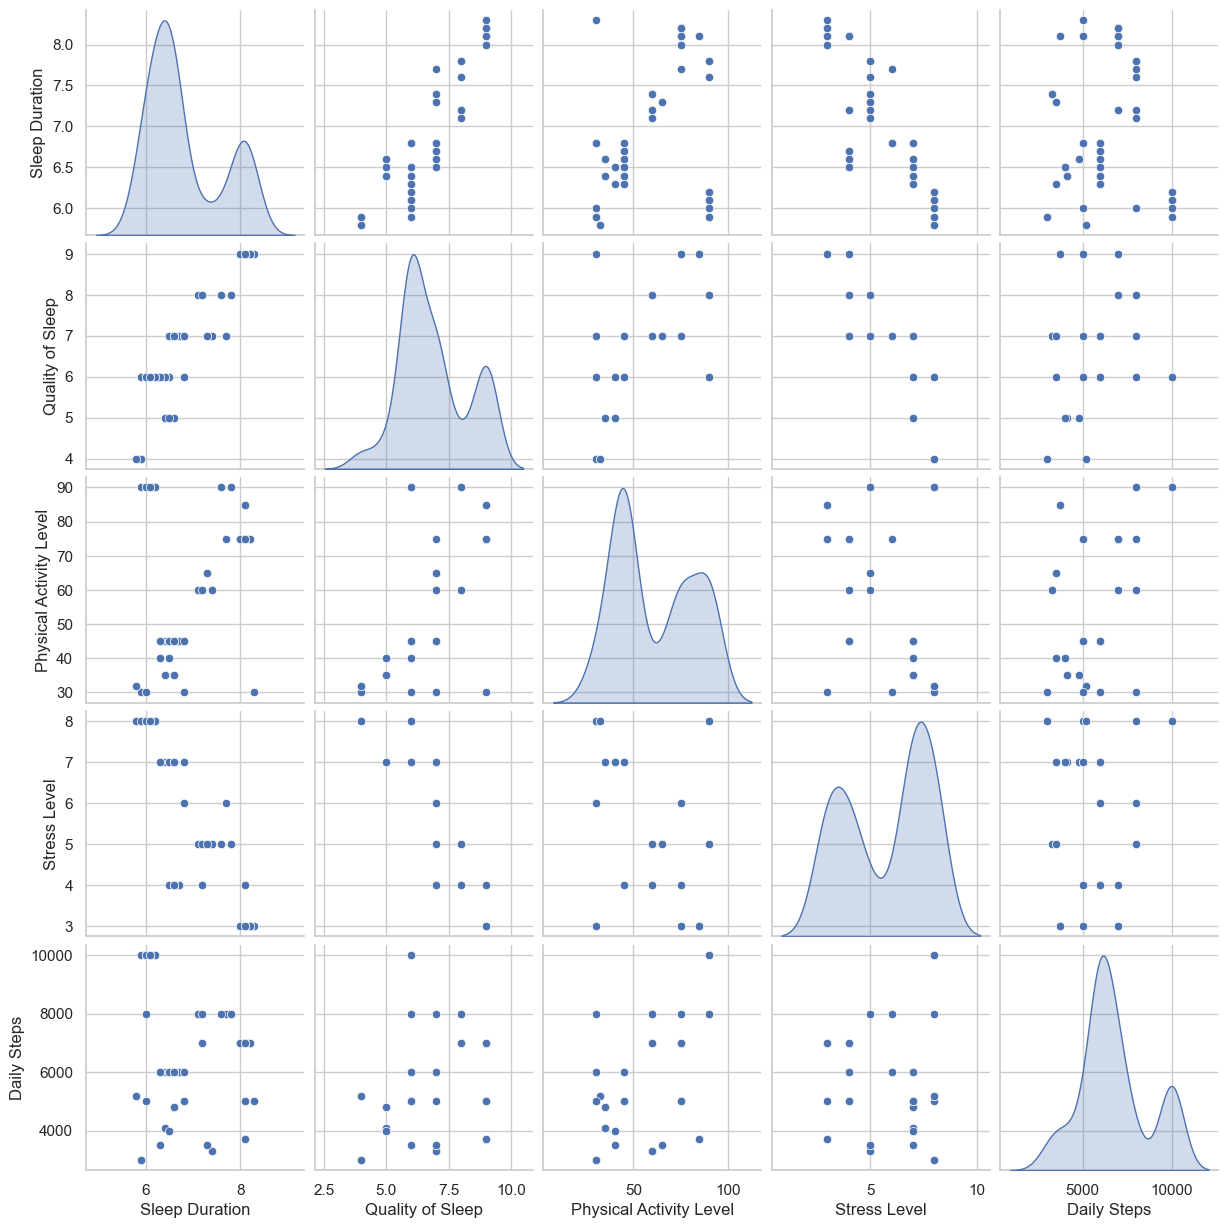

In [24]:
# -----------------------------
# Step 1: Data Visualization
# -----------------------------
sns.set(style="whitegrid")

# Distribution of Sleep Quality
plt.figure(figsize=(8, 5))
sns.histplot(data["Quality of Sleep"], kde=True, bins=10, color="blue")
plt.title("Distribution of Sleep Quality")
plt.xlabel("Quality of Sleep (scale: 1-10)")
plt.ylabel("Frequency")
plt.show()

# Boxplot: Sleep Quality by Gender
plt.figure(figsize=(8, 5))
sns.boxplot(x="Gender", y="Quality of Sleep", data=data)
plt.title("Sleep Quality by Gender")
plt.xlabel("Gender")
plt.ylabel("Quality of Sleep (scale: 1-10)")
plt.show()

# Pairplot for Numerical Variables
numerical_cols = ["Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "Daily Steps"]

# Check if you want to differentiate by a categorical variable (e.g., "Gender") using hue
# If no categorical variable is used for color, remove the 'palette' argument
sns.pairplot(data[numerical_cols], diag_kind="kde")  # No hue, no palette argument
plt.show()


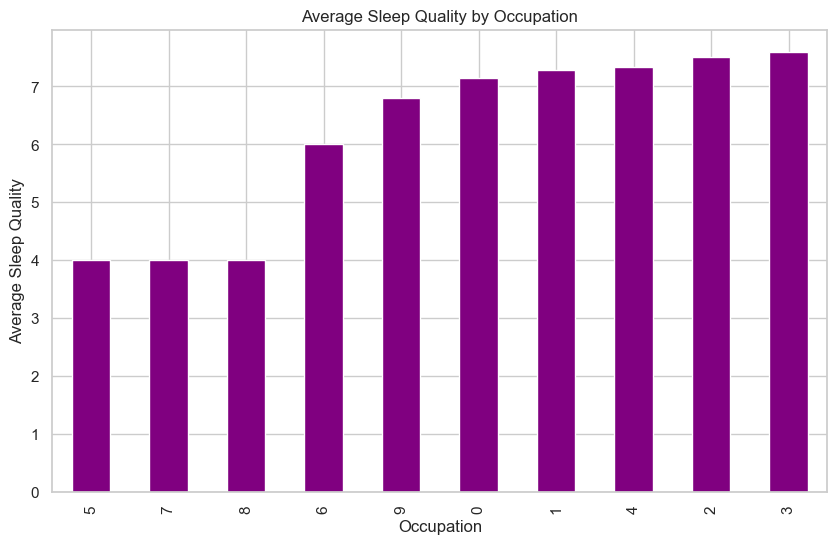

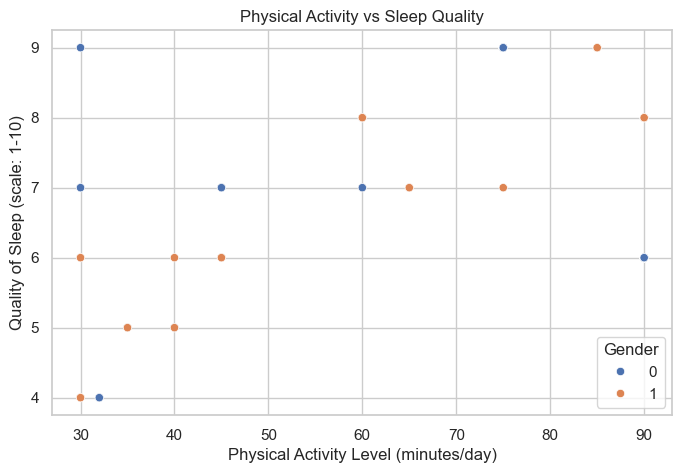

In [26]:
# -----------------------------
# Step 2: Group Analysis
# -----------------------------
# Average Sleep Quality by Occupation
grouped_occupation = data.groupby("Occupation")["Quality of Sleep"].mean().sort_values()
plt.figure(figsize=(10, 6))
grouped_occupation.plot(kind="bar", color="purple")
plt.title("Average Sleep Quality by Occupation")
plt.xlabel("Occupation")
plt.ylabel("Average Sleep Quality")
plt.show()

# Relationship Between Exercise and Sleep Quality
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Physical Activity Level", y="Quality of Sleep", hue="Gender", data=data)
plt.title("Physical Activity vs Sleep Quality")
plt.xlabel("Physical Activity Level (minutes/day)")
plt.ylabel("Quality of Sleep (scale: 1-10)")
plt.show()

Person ID                    int64
Gender                       int32
Age                          int64
Occupation                   int32
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                 int32
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder               int32
Systolic                   float64
Diastolic                  float64
dtype: object


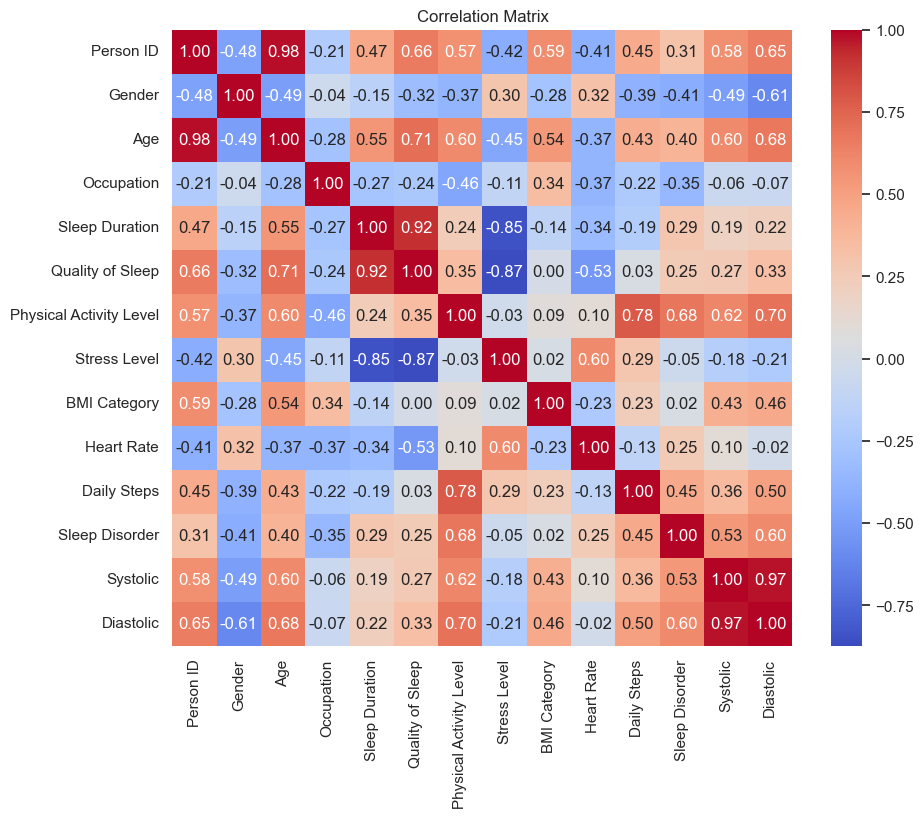

Pearson Correlation (Exercise vs Sleep Quality): 0.35
T-Test (Sleep Quality by Gender): t-stat = 4.19, p-value = 0.000
ANOVA (Sleep Quality by Occupation): F-stat = 7.21, p-value = 0.000


In [30]:
# Data Cleaning
# Check for non-numeric values and identify problematic columns
print(data.dtypes)
# Check for non-numeric values in object columns
for col in data.select_dtypes(include=['object']).columns:
    print(f"Checking column: {col}")
    print(data[col].unique())  # Print unique values to spot problematic ones
# Assuming 'Blood Pressure' is the column causing the issue, clean it
# Example: Split the 'Blood Pressure' column like '140/90' into 'Systolic' and 'Diastolic'
if 'Blood Pressure' in data.columns:
    data['Systolic'] = data['Blood Pressure'].str.split('/').str[0].astype(float)
    data['Diastolic'] = data['Blood Pressure'].str.split('/').str[1].astype(float)
    data = data.drop(columns=['Blood Pressure'])  # Drop the original 'Blood Pressure' column if needed

# Perform Correlation Analysis
# Calculate the correlation matrix for numeric columns
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Pearson Correlation: Exercise vs Sleep Quality
from scipy.stats import pearsonr
pearson_corr, _ = pearsonr(data["Physical Activity Level"], data["Quality of Sleep"])
print(f"Pearson Correlation (Exercise vs Sleep Quality): {pearson_corr:.2f}")

# T-Test: Sleep Quality by Gender
from scipy.stats import ttest_ind
gender_groups = [
    data[data["Gender"] == 0]["Quality of Sleep"],  # Male
    data[data["Gender"] == 1]["Quality of Sleep"]   # Female
]
t_stat, p_value = ttest_ind(*gender_groups)
print(f"T-Test (Sleep Quality by Gender): t-stat = {t_stat:.2f}, p-value = {p_value:.3f}")

# ANOVA: Sleep Quality by Occupation
from scipy.stats import f_oneway
occupations = [data[data["Occupation"] == i]["Quality of Sleep"] for i in data["Occupation"].unique()]
anova_stat, anova_p = f_oneway(*occupations)
print(f"ANOVA (Sleep Quality by Occupation): F-stat = {anova_stat:.2f}, p-value = {anova_p:.3f}")

In [32]:
# -----------------------------
# Step 4: Regression Analysis
# -----------------------------
# Predict Sleep Quality Based on Exercise, Stress, and Gender
X = data[["Physical Activity Level", "Stress Level", "Gender"]]
y = data["Quality of Sleep"]

model = LinearRegression()
model.fit(X, y)

print("\nRegression Coefficients:")
for col, coef in zip(X.columns, model.coef_):
    print(f"{col}: {coef:.2f}")

print(f"Intercept: {model.intercept_:.2f}")


Regression Coefficients:
Physical Activity Level: 0.02
Stress Level: -0.61
Gender: 0.21
Intercept: 8.90
